In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import analyze

Loading antenna pattern from /home/gal_aharoni_vayyar_com/openems/src/sim/antenna_array/farfield_1x1_60x60_2450_steer_t0_p0.h5
Loading antenna pattern from /home/gal_aharoni_vayyar_com/openems/src/sim/antenna_array/farfield_1x1_90x90_2450_steer_t0_p0.h5
Loading antenna pattern from /home/gal_aharoni_vayyar_com/openems/src/sim/antenna_array/farfield_2x1_60x60_2450_steer_t0_p0.h5
Loading antenna pattern from /home/gal_aharoni_vayyar_com/openems/src/sim/antenna_array/farfield_2x1_90x90_2450_steer_t0_p0.h5
Loading antenna pattern from /home/gal_aharoni_vayyar_com/openems/src/sim/antenna_array/farfield_4x1_60x60_2450_steer_t0_p0.h5
Loading antenna pattern from /home/gal_aharoni_vayyar_com/openems/src/sim/antenna_array/farfield_4x1_90x90_2450_steer_t0_p0.h5


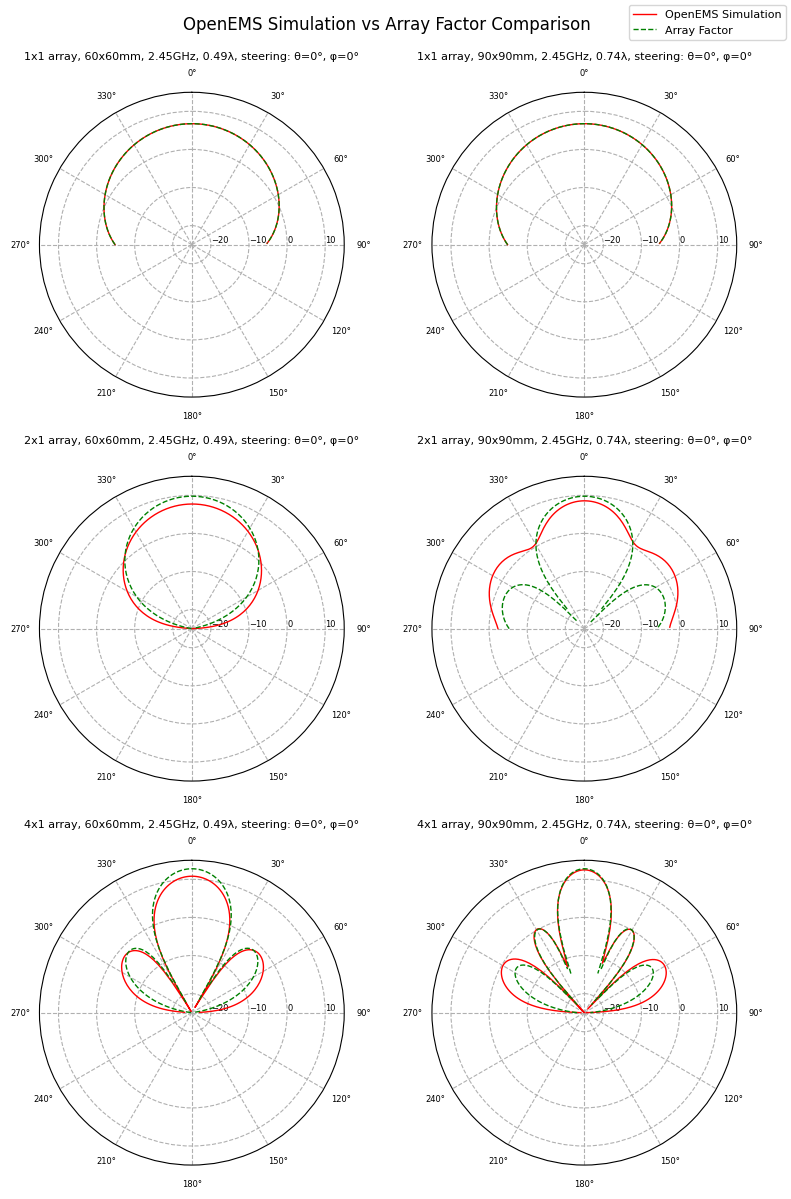

In [3]:
# Standard array comparison without beamsteering
analyze.plot_sim_and_af(
    sim_dir=Path.cwd() / "src" / "sim" / "antenna_array",
    freq=2.45e9,
    xns=[1, 2, 4],
    yn=1,
    dxs=[60, 90],
    figname="antenna_array_comparison",
)

Loading antenna pattern from /home/gal_aharoni_vayyar_com/openems/src/sim/antenna_array/farfield_4x4_60x60_2450_steer_t0_p0.h5


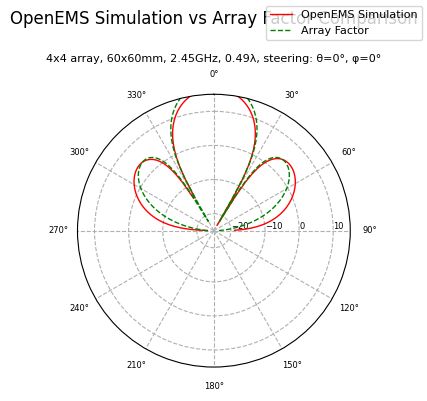

In [4]:
# Array comparison with beamsteering at 30 degrees
analyze.plot_sim_and_af(
    sim_dir=Path.cwd() / "src" / "sim" / "antenna_array",
    freq=2.45e9,
    xns=[4],  # Only showing 4-element arrays which should have beamsteering sims
    yn=4,
    dxs=[60],
    steering_theta=0,  # 30 degree beam steering
    figname="antenna_array_beamsteering_30deg",
)

Loading antenna pattern from /home/gal_aharoni_vayyar_com/openems/src/sim/antenna_array/farfield_4x4_60x60_2450_steer_t15_p0.h5


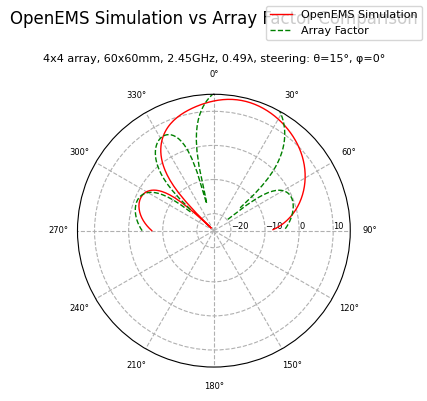

In [5]:
# Array comparison with beamsteering at 30 degrees
analyze.plot_sim_and_af(
    sim_dir=Path.cwd() / "src" / "sim" / "antenna_array",
    freq=2.45e9,
    xns=[4],  # Only showing 4-element arrays which should have beamsteering sims
    yn=4,
    dxs=[60],
    steering_theta=15,  # 30 degree beam steering
    figname="antenna_array_beamsteering_30deg",
)

Loading antenna pattern from /home/gal_aharoni_vayyar_com/openems/src/sim/antenna_array/farfield_16x16_60x60_2450_steer_t0_p0.h5


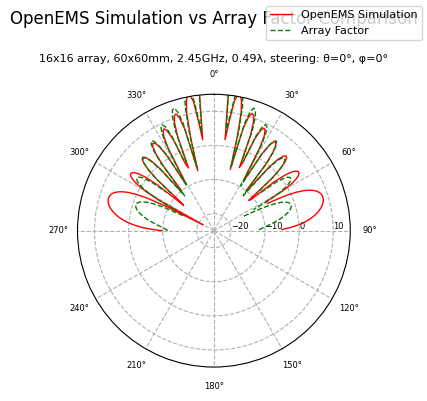

In [6]:
# Array comparison with beamsteering at 30 degrees
analyze.plot_sim_and_af(
    sim_dir=Path.cwd() / "src" / "sim" / "antenna_array",
    freq=2.45e9,
    xns=[16],  # Only showing 4-element arrays which should have beamsteering sims
    yn=16,
    dxs=[60],
    steering_theta=0,  # 30 degree beam steering
    figname="antenna_array_beamsteering_00deg",
)

Loading antenna pattern from /home/gal_aharoni_vayyar_com/openems/src/sim/antenna_array/farfield_16x16_60x60_2450_steer_t15_p0.h5


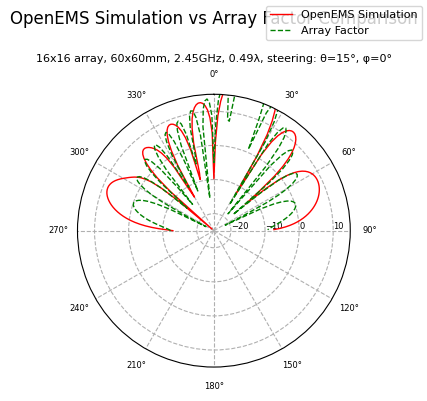

In [7]:
# Array comparison with beamsteering at 30 degrees
analyze.plot_sim_and_af(
    sim_dir=Path.cwd() / "src" / "sim" / "antenna_array",
    freq=2.45e9,
    xns=[16],  # Only showing 4-element arrays which should have beamsteering sims
    yn=16,
    dxs=[60],
    steering_theta=15,  # 30 degree beam steering
    figname="antenna_array_beamsteering_15deg",
)